# Introduction to sqlite and SQL  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.io import sql
import sqlite3

/Users/michaeltwardos/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
conn = sqlite3.connect('eliflo.db', detect_types=sqlite3.PARSE_DECLTYPES)

### Setup

In [3]:
#The data has information about when eliflo users signed up and other metadata about them.
data = pd.read_csv('eliflo_user.csv', low_memory=False)
data.head()

,customerid,datecreated,source,mailinglist,testgroup,orgid,parentid
0,3861,1338425007,ORG_INVITE,0,0,115,3861
1,11430,1338428551,ORG_INVITE,0,0,239,5677
2,7170,1338445431,ORG_INVITE,0,0,145,7170
3,10012,1338452406,ORG_INVITE,0,1,225,7104
4,11999,1338465359,PERSONAL_PROJECTS,0,0,6,NULL


In [4]:
#Put data into the eliflo DB
data.to_sql('eliflo_users',
            con=conn,
            if_exists='replace',
            index=False)

### Count, Sum, Average

In [5]:
#Our first query in python sqlite!  What does * mean?
#Who knows the HelloWorld of SQL?
a=sql.read_sql('''
select * from eliflo_users
limit 3;
''', con=conn)
a
#Question - Given a new data set in SQL, what are ways you start categorizing a data set?  
#What is the equivalent of df.describe?

,customerid,datecreated,source,mailinglist,testgroup,orgid,parentid
0,3861,1338425007,ORG_INVITE,0,0,115,3861
1,11430,1338428551,ORG_INVITE,0,0,239,5677
2,7170,1338445431,ORG_INVITE,0,0,145,7170


In [6]:
#See what tables currently exist in your database.
a=sql.read_sql('''
SELECT name FROM sqlite_master WHERE type = "table";
''', con=conn)
a

,name
0,eliflo_activity
1,eliflo_master_fact
2,eliflo_users


In [7]:
#Examples of count, sum and average functions
a=sql.read_sql('''
select  
    count(*)  as num_of_rows,
    count(distinct(customerid))  as distinct_customers,
    sum(mailinglist) as num_mailing,
    avg(mailinglist) as mailing_probability
from 
    eliflo_users ;
''', con=conn)
a

,num_of_rows,distinct_customers,num_mailing,mailing_probability
0,10000,10000,2486,0.2486


How many distinct users (parentid) invited a customer?

### Min, Max

In [8]:
#use min, max and date to compute date range.
#Date functionality is very useful.
a=sql.read_sql('''
select  
    date(min(datecreated), 'unixepoch') as start_date, 
    date(max(datecreated), 'unixepoch') as end_date
from 
    eliflo_users ;
''', con=conn)
a

,start_date,end_date
0,2012-05-31,2014-03-19


### Case

In [9]:
#Example of using case 
a=sql.read_sql('''
select  
    sum(case when mailinglist = 1 then 1 else 0 end) as mailing_true,
    sum(case when mailinglist = 0 then 1 else 0 end) as mailing_false 
from 
    eliflo_users ;
''', con=conn)
a

,mailing_true,mailing_false
0,2486,7514


Use case to measure how many customers were invited by someone

### Group By

In [ ]:
#Show signups per day
a=sql.read_sql('''
select 
    date(datecreated, 'unixepoch') as day_created, 
    count(*) as new_users 
from 
    eliflo_users 
group by 1
''', con=conn)
a.plot()

How many users came through each source?

In [10]:
#What are the most popular sources that users came from?
a=sql.read_sql('''
select 
    source, 
    count(*) as new_users 
from 
    eliflo_users 
group by 1 
order by 2 desc;
''', con=conn)
a

,source,new_users
0,ORG_INVITE,3535
1,GUEST_INVITE,1799
2,PERSONAL_PROJECTS,1790
3,SIGNUP,1735
4,SIGNUP_GOOGLE_AUTH,1141


### Modulo

In [ ]:
#Bucketing users.  Good for experiments!
a=sql.read_sql('''
select 
    customerid % 4, 
    count(*) as new_users 
from 
    eliflo_users 
group by 1
''', con=conn)
a

### Growth Analytics with Master Fact 

In [22]:
#Get data about these users subsequent activity
activities = pd.read_csv('eliflo_activities.csv', low_memory=False)
activities.head()

,customerid,timestamp,eventtype
0,10012,1338452406,login
1,3428,1338479256,login
2,9899,1338484777,login
3,1693,1338501513,login
4,6102,1338509850,login


In [23]:
#Convert activity to sqlite
activity.to_sql('eliflo_master_fact',
            con=conn,
            if_exists='replace',
            index=False)

### Subquery

In [ ]:
#Example of a subquery
a=sql.read_sql('''
select
visits,
count(distinct(customerid)) as customers
from
(
select
    customerid,
    count(*) as visits
from
    eliflo_master_fact
where
    eventtype = 'login'
group by 1 
) q
group by 1 
order by 2 desc;
    ''', con=conn)
a.head(5)
               

### Join Example

In [ ]:
Give me the users that were active one day that were also active another day.

In [ ]:
#This query show the percentage of customers per cohort that were active in the second week after they signed up.
a=sql.read_sql('''
select
    count(distinct(b.customerid)) as returning_users
from
    eliflo_master_fact a
left join
    eliflo_master_fact b
on
    a.customerid = b.customerid
where
    substr(date(a.timestamp, 'unixepoch'), 1,10)='2014-01-01' and
    substr(date(b.timestamp, 'unixepoch'), 1,10)='2014-01-07'
    ''', con=conn)
a.head(10)

### Measuring a Growth Susceptibility: Retention Rate

In [ ]:
#This query show the percentage of customers per cohort that were active in the second week after they signed up.
a=sql.read_sql('''
select 
    a.day_created,
    cast(returning_users as real)/new_users
from
(
select
    substr(date(datecreated, 'unixepoch'), 1,7) as day_created,
    count(distinct(customerid)) as new_users
from
    eliflo_users 
group by 1
) a
left join
(
select
    substr(date(a.datecreated, 'unixepoch'), 1,7) as day_created,
    count(distinct(b.customerid)) as returning_users
from
    eliflo_users a
left join
    eliflo_activity b
on
    a.customerid = b.customerid
where
    b.timestamp between a.datecreated + 7*86400 and a.datecreated + 14*86400
group by 1
) b
on a.day_created = b.day_created
    ''', con=conn)
a.head(10)

In [ ]:
#This query looks at the retention rate for a selected cohort.
a=sql.read_sql('''
select 
    month as age_in_months,
    cast(returning_users as real)/initial_cohort as retention_rate
from
(select
   cast((b.timestamp - a.datecreated)/(86400*30) as int) as month,
    count(distinct(b.customerid)) as returning_users
from
    eliflo_users a
left join
    eliflo_activity b
on
    a.customerid = b.customerid
where
    substr(date(a.datecreated, 'unixepoch'), 1,7) = '2012-06' and
    cast((b.timestamp - a.datecreated)/(86400*30) as int) >= 0
group by 1) a,
(select
    count(distinct(customerid)) as initial_cohort
from
    eliflo_users a
where
    substr(date(a.datecreated, 'unixepoch'), 1,7) = '2012-06' 
)
    ''', con=conn)
a.head(5)

In [25]:
#Generalizing the calculation of a retention curve
def constructRetentionCurve(month):
    string = '''
    select 
        month,
        cast(returning_users as real)/initial_cohort as retention_rate
    from
    (select
        cast((b.timestamp - a.datecreated)/(86400*30) as int) as month,
        count(distinct(b.customerid)) as returning_users
    from
        eliflo_users a
    left join
        eliflo_master_fact b
    on
        a.customerid = b.customerid
    where
        substr(date(a.datecreated, 'unixepoch'), 1,7) = '%s' and
        cast((b.timestamp - a.datecreated)/(86400*30) as int) >= 0
    group by 1) a,
    (select
        count(distinct(customerid)) as initial_cohort
    from
        eliflo_users a
    where
        substr(date(a.datecreated, 'unixepoch'), 1,7) = '%s'  
    )
    ''' % (month, month)
    return string

In [26]:
a=sql.read_sql(constructRetentionCurve('2012-10'), con=conn)
b=sql.read_sql(constructRetentionCurve('2012-06'), con=conn)
#How do we join the retention curves together?

In [ ]:
a.head()

In [16]:
def linearG(t, b, m):
    if t < 0:
        return 0
    if t == 0:
        return 0.75
    elif b - m*t  > 0:
        return round(b -m*t, 3)
    else:
        return 0

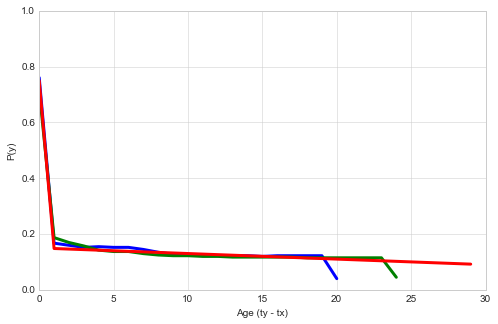

In [17]:
plt.figure(figsize=(8,5))
plt.style.use('seaborn-whitegrid')
plt.rc('lines', linewidth=3)
plt.plot([item for item in a['month']] ,[item for item in a['retention_rate']]) 
plt.plot([item for item in b['month']] ,[item for item in b['retention_rate']]) 
plt.plot([item for item in range(30)] ,[linearG(item, 0.15, 0.002) for item in range(30)]) 
plt.xlabel('Age (ty - tx)')
plt.ylabel('P(y)')
plt.ylim((0,1))
plt.show()

In [43]:
def computeYLin(cohorts, daysOut, b, m):
    currentDay = len(cohorts)
    Y = []
    #First Calculate DAU while cohorts are being acquired
    for t in range(currentDay):
        actives=[]
        for i in range(t):
            actives.append(round(cohorts[t-i]*linearG(i, b, m), 3))
        Y.append(sum(actives))
    #Now calculate more DAU as we project out after acquiring cohorts
    for t in range(daysOut):
        actives=[]
        for i in range(currentDay):
            actives.append(round(cohorts[currentDay-i-1]*linearG(t+i-1, b, m), 3))
        Y.append(sum(actives))
    return Y 

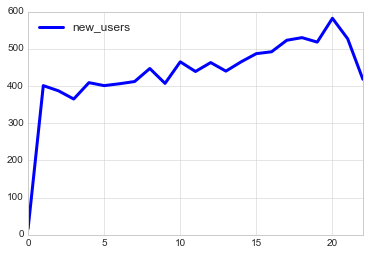

In [28]:
#Show signups per day
new_users=sql.read_sql('''
select 
    substr(date(datecreated, 'unixepoch'), 1,7) as month_created, 
    count(*) as new_users 
from 
    eliflo_users 
group by 1
''', con=conn)
new_users.plot()

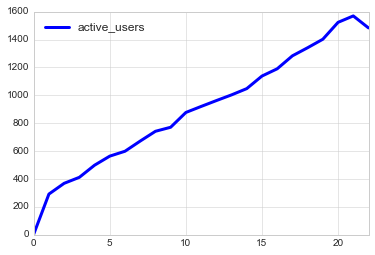

In [30]:
#Show signups per day
dau=sql.read_sql('''
select 
    substr(date(timestamp, 'unixepoch'), 1,7) as month_active, 
    count(distinct(customerid)) as active_users 
from 
    eliflo_master_fact
group by 1
''', con=conn)
dau.plot()

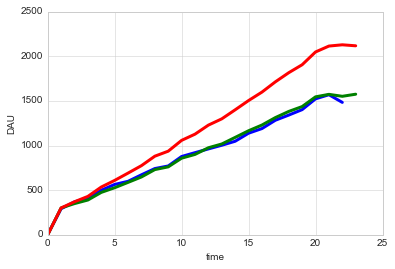

In [48]:
cohorts = [item for item in new_users['new_users']]
results=pd.DataFrame(computeYLin(cohorts, 1, 0.15, 0.002))
plt.figure(figsize=(6,4))
plt.style.use('seaborn-whitegrid')
plt.xlabel('time')
plt.ylabel('DAU')
plt.plot(dau['active_users'])
plt.plot(results)
#What is we half the rate of decay and increase the initial intercept?
#results2=pd.DataFrame(computeYLin(cohorts, 1, 0.2, 0.001))
#plt.plot(results2)

plt.show()